<a href="https://colab.research.google.com/github/avner8943/ml/blob/master/RNN_o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error:[3.45638663]
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 0 0 0 1 0 1]
9 + 60 = 1
------------
Error:[3.63389116]
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 1 1 1 1 1]
28 + 35 = 255
------------
Error:[3.91366595]
Pred:[0 1 0 0 1 0 0 0]
True:[1 0 1 0 0 0 0 0]
116 + 44 = 72
------------
Error:[3.72191702]
Pred:[1 1 0 1 1 1 1 1]
True:[0 1 0 0 1 1 0 1]
4 + 73 = 223
------------
Error:[3.5852713]
Pred:[0 0 0 0 1 0 0 0]
True:[0 1 0 1 0 0 1 0]
71 + 11 = 8
------------
Error:[2.53352328]
Pred:[1 0 1 0 0 0 1 0]
True:[1 1 0 0 0 0 1 0]
81 + 113 = 162
------------
Error:[0.57691441]
Pred:[0 1 0 1 0 0 0 1]
True:[0 1 0 1 0 0 0 1]
81 + 0 = 81
------------
Error:[1.42589952]
Pred:[1 0 0 0 0 0 0 1]
True:[1 0 0 0 0 0 0 1]
4 + 125 = 129
------------
Error:[0.47477457]
Pred:[0 0 1 1 1 0 0 0]
True:[0 0 1 1 1 0 0 0]
39 + 17 = 56
------------
Error:[0.21595037]
Pred:[0 0 0 0 1 1 1 0]
True:[0 0 0 0 1 1 1 0]
11 + 3 = 14
------------


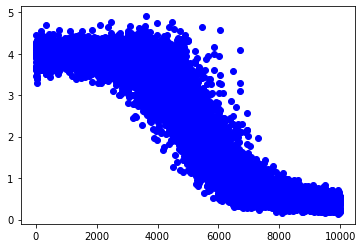

In [3]:
import copy, numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt


# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)


# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(
    np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]


# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1


# initialize neural network weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1

synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)
errors = []
# training logic
for j in range(10000):
    
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary encoding

    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary encoding

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # where we'll store our best guess (binary encoded)
    d = np.zeros_like(c)

    overallError = 0
    
    layer_2_deltas = list()
    layer_1_values = list()
    layer_1_values.append(np.zeros(hidden_dim))
    
    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))

        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))

        # did we miss?... if so, by how much?
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
        overallError += np.abs(layer_2_error[0])
    
        # decode estimate so we can print it out
        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        
        # store hidden layer so we can use it in the next timestep
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
    for position in range(binary_dim):
        
        X = np.array([[a[position],b[position]]])
        layer_1 = layer_1_values[-position-1]
        prev_layer_1 = layer_1_values[-position-2]
        
        # error at output layer
        layer_2_delta = layer_2_deltas[-position-1]
        # error at hidden layer
        layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)

        # let's update all our weights so we can try again
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        synapse_0_update += X.T.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    errors.append(overallError)

    synapse_0 += synapse_0_update * alpha
    synapse_1 += synapse_1_update * alpha
    synapse_h += synapse_h_update * alpha    

    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0
    
    # print out progress
    if(j % 1000 == 0):
        print ("Error:" + str(overallError))
        print ("Pred:" + str(d))
        print ("True:" + str(c))
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print (str(a_int) + " + " + str(b_int) + " = " + str(out))
        print ("------------")

plt.plot(list(range(len(errors))), errors,  'bo')
plt.show()       